In [1]:
import ee
import geemap
import os
from datetime import datetime, timedelta
import numpy as np
import geopandas as gpd
import pandas as pd
import math
import matplotlib.pyplot as plt
import geemap

In [7]:
def get_image_near_point(im_collection_id, im_date,  bands_rgb, latitude, longitude, buffer_px, 
                        return_geopandas = False):
    """
    Get an earth engine image near a point

    Parameters
    ----------
    im_collection_id : str
        DESCRIPTION.
    im_date : str
        DESCRIPTION.
    bands_rgb : list
        Band names.
    latitude : float
        Latitude (EPSG 4326).
    longitude : float
        Longitude (EPSG 4326).
    buffer_px : int
        Number of pixels to buffer on each side.
    return_geopandas : bool, optional
        If True, return geopandas.DataFrame, otherwise np.array. The default is False.

    Returns
    -------
    return_val : np.array or geopandas.DataFrame
        m x n grid with bands specified by bands_rgb.
        
    
    Examples
    --------
    im_array = get_image_near_point(im_collection_id = 'COPERNICUS/S2_SR', 
                                    im_date = '2020-02-03',  
                                    bands_rgb = ['B8','B4','B3'], 
                                    latitude = 11.4086, 
                                    longitude = 77.7791, 
                                    buffer_px = 10, 
                                    return_geopandas = False)
    plt = plot_array_image(im_array1)
    plt.show()

    """
    
    
        
    start_datetime = datetime.strptime(im_date,'%Y-%m-%d')
    end_date = datetime.strftime(start_datetime + timedelta(days = 1), '%Y-%m-%d')
    
    try:
        pt = ee.Geometry.Point([longitude, latitude])
    except:
        ee.Initialize()
        pt = ee.Geometry.Point([longitude, latitude])
        
    # pt_bbox = pt.buffer(buffer_m, 1).bounds()
    ic = ee.ImageCollection(im_collection_id).filterBounds(pt).filterDate(im_date, end_date)
    # ic = ic.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 0.25))
    im = ic.first().select(bands_rgb)

    if return_geopandas:
        im = im.addBands(im.pixelCoordinates(im.projection()))
    
    # buffer_px = 10
    # generate kernel
    imdim = (buffer_px * 2) + 1
    kernel_list = ee.List.repeat(1, imdim)
    kernel_lists = ee.List.repeat(kernel_list, imdim)
    kernel = ee.Kernel.fixed(imdim, imdim, kernel_lists, 
                             x = buffer_px, y = buffer_px)
    
    
    im_eearray = im.neighborhoodToArray(kernel)
    
    
    # sample the region and return array from ee to python
    im_dict = im_eearray.reduceRegion(ee.Reducer.first(), geometry = pt, scale = 10).getInfo()
    # # old, with bounding box:
    # im_dict = im.sampleRectangle(region = pt_bbox, properties = []).getInfo()
    # im_props = im_dict['properties']

    # len(im_dict['properties'])
    im_props = im_dict
    im_props_keys = list(im_props.keys())

    if return_geopandas:
        df = pd.DataFrame()
        for i in range(len(im_props)):
            colname = im_props_keys[i]
            data = np.array(im_props[colname]).flatten()
            df[colname] = data

        im_projection = im.projection().getInfo()
        # convert to geopandas
        gdf = gpd.GeoDataFrame(df, 
                 geometry = gpd.points_from_xy(df.x, df.y),
                 crs = im_projection['crs'])
        
        return_val = gdf


    else:
        # extract each band separately
        Bred = np.expand_dims(np.array(im_props[bands_rgb[0]]), 2)
        Bgreen = np.expand_dims(np.array(im_props[bands_rgb[1]]), 2)
        Bblue = np.expand_dims(np.array(im_props[bands_rgb[2]]), 2)

        im_array_rgb = np.concatenate((Bred, Bgreen, Bblue), axis = 2)
        return_val = im_array_rgb
    
    return return_val



# @st.cache
def plot_array_image(im_array):
    xcenter = math.floor(im_array.shape[0] / 2)
    ycenter = math.floor(im_array.shape[1] / 2)
    
    maxval = 5000
    
    im_array[im_array > maxval] = maxval
    
    arrow_spacing = 1
    # Scale the data to [0, 255] to show as an RGB image.
    rgb_img_test = (255*((im_array - 0)/maxval)).astype('uint8')
    plt.figure(figsize = (5,5),dpi = 100)
    # plt.axis('off')
    plt.imshow(rgb_img_test)
    plt.plot(xcenter, ycenter - arrow_spacing, marker = 'v', color = 'white')
    plt.plot(xcenter, ycenter + arrow_spacing,marker = '^', color = 'white')
    plt.plot(xcenter + arrow_spacing, ycenter, marker = '<', color = 'white')
    plt.plot(xcenter - arrow_spacing, ycenter,marker = '>', color = 'white')
    return plt

In [3]:
ee.Initialize()

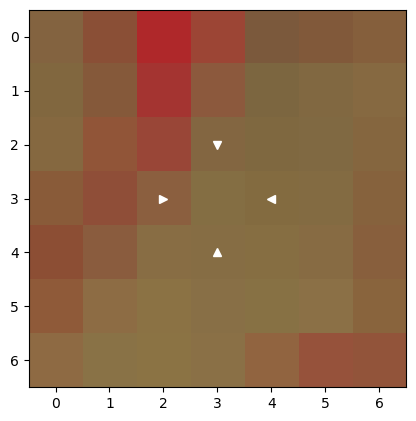

In [14]:
lat = 11.34594969935525 #11.4086, 
lon = 77.84800629839049 #77.7791, 
im_date = '2019-06-08' #,'2020-02-03',  
im_date2 = '2020-02-04'

im_array = get_image_near_point(im_collection_id = 'COPERNICUS/S2_SR', 
                                im_date = im_date,
                                bands_rgb = ['B8','B4','B3'], 
                                latitude = lat,
                                longitude = lon,
                                buffer_px = 3, 
                                return_geopandas = False)
plt = plot_array_image(im_array)
plt.show()

In [15]:
pt = ee.Geometry.Point([lon, lat])
s2 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(im_date, im_date2).filterBounds(pt)

In [16]:
Map = geemap.Map()
Map.centerObject(pt, 18)
Map.addLayer(s2.mosaic(), {'bands' : ['B8','B4','B3'], 'min' : 0, 'max' : 5000}, 's2')
Map.addLayer(pt, {}, 'pt')
Map.addLayerControl()
Map


Map(center=[11.34594969935525, 77.84800629839049], controls=(WidgetControl(options=['position', 'transparent_b…

In [18]:

px_around_pt = 10
imdim = (px_around_pt * 2) + 1
kernel_list = ee.List.repeat(1, imdim)
kernel_lists = ee.List.repeat(kernel_list, imdim)
kernel = ee.Kernel.fixed(imdim, imdim, kernel_lists, 
                         x = px_around_pt + 1, y = px_around_pt + 1)
# kernel.getInfo()
s2im = s2.mosaic().select(['B8','B4','B3'])
s2ar_ee = s2im.neighborhoodToArray(kernel)
s2ar = s2ar_ee.reduceRegion(ee.Reducer.first(), geometry = pt, scale = 10).getInfo()

In [19]:
s2im.projection().getInfo()

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

In [40]:
import numpy as np
import matplotlib.pyplot as plt
B3 = np.expand_dims(np.array(s2ar['B3']), 2)
B4 = np.expand_dims(np.array(s2ar['B4']), 2)
B8 = np.expand_dims(np.array(s2ar['B8']), 2)

maxval = 3000
im_array = np.concatenate((B8, B4, B3), axis = 2)
im_array[im_array > maxval] = maxval


rgb_img_test = (255*((im_array - 0)/maxval)).astype('uint8')

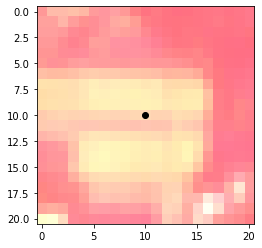

In [46]:
plt.imshow(rgb_img_test)
plt.plot(10, 10, marker = 'o', color = 'black')